In [3]:
import pandas as pd
import numpy as np
import os

RESULTS_CSV = "../results/results_v4.csv"
OUTDIR = "../analysis/analysis_v4"
os.makedirs(OUTDIR, exist_ok=True)

print(f"Loading {RESULTS_CSV}...")
df = pd.read_csv(RESULTS_CSV)
df.drop(['seed', 'sec_per_run'], axis=1, inplace=True)

# ------------------------------------------------------
# 1. Derived Columns
# ------------------------------------------------------
df["combo_p_err"] = df["error_rate"] + df["p_meas_err"]
df["err_rate_change"] = ((df["combo_p_err"] - df["OSDW_WER"]) / df["OSDW_WER"])
df["xyz_bias"] = df["xyz_bias"].astype(str)  # make sure it's stringified for grouping
df["channel_update"] = df["channel_update"].astype(str)
df["channel_update"] = df["channel_update"].replace("nan", "None")

Loading results_v4.csv...


In [752]:
# ------------------------------------------------------
# 2. Hadamard Bias-Tailoring Analysis
# ------------------------------------------------------
bias_tailor_group_cols = [
    "error_rate", "p_meas_err", "xyz_bias", "run_ss", "apply_ss", "channel_update"
]

hadamard_effect = df.groupby(bias_tailor_group_cols + ["hadamard_rotate"])["OSDW_WER"].agg(["mean"]).unstack()
# Flatten multiindex to strings like 'mean_no_Hrot', etc.
hadamard_effect.columns = [
    f"{agg}_{'Hrot' if hrot else 'no_Hrot'}"
    for agg, hrot in hadamard_effect.columns
]
hadamard_effect["WER_delta"] = (hadamard_effect["mean_Hrot"] - hadamard_effect["mean_no_Hrot"])
hadamard_effect["WER_rel_change"] = (hadamard_effect["WER_delta"] / hadamard_effect["mean_no_Hrot"])
hadamard_effect.to_csv(f"{OUTDIR}/hadamard_effect.csv")

In [754]:
hadamard_effect

mean_no_Hrot  \
error_rate p_meas_err xyz_bias     run_ss apply_ss channel_update                 
0.00       0.00       [1, 1, 1000] False  False    None                 0.00000   
                                   True   False    None                 0.00000   
                                          True     None                 0.00000   
                      [1, 1, 100]  False  False    None                 0.00000   
                                   True   False    None                 0.00000   
...                                                                         ...   
0.08       0.04       [5, 1, 1]    True   False    None                 1.00000   
                                          True     None                 1.00000   
                      [50, 1, 1]   False  False    None                 0.12883   
                                   True   False    None                 1.00000   
                                          True     None                 1.00000   

                                                                   mean_Hrot  \
error_rate p_meas_err xyz_bias     run_ss apply_ss channel_update              
0.00       0.00       [1, 1, 1000] False  False    None             0.000000   
                                   True   False    None             0.000000   
                                          True     None             0.000000   
                      [1, 1, 100]  False  False    None             0.000000   
                                   True   False    None             0.000000   
...                                                                      ...   
0.08       0.04       [5, 1, 1]    True   False    None             1.000000   
                                          True     None             1.000000   
                      [50, 1, 1]   False  False    None             0.078268   
                                   True   False    None             1.000000   
                                          True     None             1.000000   

                                                                   WER_delta  \
error_rate p_meas_err xyz_bias     run_ss apply_ss channel_update              
0.00       0.00       [1, 1, 1000] False  False    None             0.000000   
                                   True   False    None             0.000000   
                                          True     None             0.000000   
                      [1, 1, 100]  False  False    None             0.000000   
                                   True   False    None             0.000000   
...                                                                      ...   
0.08       0.04       [5, 1, 1]    True   False    None             0.000000   
                                          True     None             0.000000   
                      [50, 1, 1]   False  False    None            -0.050562   
                                   True   False    None             0.000000   
                                          True     None             0.000000   

                                                                   WER_rel_change  
error_rate p_meas_err xyz_bias     run_ss apply_ss channel_update                  
0.00       0.00       [1, 1, 1000] False  False    None                       NaN  
                                   True   False    None                       NaN  
                                          True     None                       NaN  
                      [1, 1, 100]  False  False    None                       NaN  
                                   True   False    None                       NaN  
...                                                                           ...  
0.08       0.04       [5, 1, 1]    True   False    None                  0.000000  
                                          True     None                  0.000000  
                      [50, 1, 1]   False  False    None          

In [756]:
# ------------------------------------------------------
# 3. Single-Shot Application Modes (clean version)
# ------------------------------------------------------

# Step 1: Filter
# df_none = df[df["channel_update"] == "None"]

# Step 2: Group and unstack
ss_modes_group = ["error_rate", "p_meas_err", "xyz_bias", "hadamard_rotate", "channel_update"]

ss_effect = df.groupby(ss_modes_group + ["run_ss", "apply_ss"])["OSDW_WER"] \
                   .agg(["mean"]) \
                   .unstack(level=["run_ss", "apply_ss"])

# Step 3: Rename columns
col_map = {
    ('mean', False, False): "ssFalse",
    ('mean', True, False):  "ssTrue_applyFalse",
    ('mean', True, True):   "ssTrue_applyTrue"
}

# Flatten and relabel
ss_effect.columns = [col_map.get(col, f"{col}") for col in ss_effect.columns]
ss_effect = ss_effect.reset_index()
ss_effect.to_csv(f"{OUTDIR}/ss_apply_effect.csv", index=False)

In [758]:
ss_effect

,error_rate,p_meas_err,xyz_bias,hadamard_rotate,channel_update,ssFalse,ssTrue_applyFalse,ssTrue_applyTrue
0,0.00,0.00,"[1, 1, 1000]",False,None,0.000000,0.0,0.0
1,0.00,0.00,"[1, 1, 1000]",True,None,0.000000,0.0,0.0
2,0.00,0.00,"[1, 1, 100]",False,None,0.000000,0.0,0.0
3,0.00,0.00,"[1, 1, 100]",True,None,0.000000,0.0,0.0
4,0.00,0.00,"[1, 1, 10]",False,None,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
523,0.08,0.04,"[1000, 1, 1]",True,None,0.050932,1.0,1.0
524,0.08,0.04,"[5, 1, 1]",False,None,1.000000,1.0,1.0
525,0.08,0.04,"[5, 1, 1]",True,None,1.000000,1.0,1.0
526,0.08,0.04,"[50, 1, 1]",False,None,0.128830,1.0,1.0


In [9]:
#!/usr/bin/env python
"""
Analysis + visualisation for results_v2 sweep
=============================================
• Requires: pandas, matplotlib
• Usage   : python analyze_and_plot_v2.py
"""

import os, ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. I/O helpers
# ----------------------------------------------------------------------
CSV_DIR  = "."          # change if needed
PLOT_DIR = "../plots/v4"
os.makedirs(PLOT_DIR, exist_ok=True)

def load(name):
    path = os.path.join(CSV_DIR, name)
    print("↪ loading", path)
    return pd.read_csv(path)

had  = load(f"{OUTDIR}/hadamard_effect.csv")
ss   = load(F"{OUTDIR}/ss_apply_effect.csv")

↪ loading ./analysis_v4/hadamard_effect.csv
↪ loading ./analysis_v3/ss_apply_effect.csv


### Hrot Analysis

In [960]:
# ----------------------------------------------------------------------
# 2. Bias‑Tailoring ΔWER vs. xyz bias ratio
# ----------------------------------------------------------------------
# derive a bias ratio (Z‑over‑X) column from index string '[x, 1, z]'
def z_over_x_ratio(bias_str):
    x, _, z = ast.literal_eval(bias_str)
    return z / x

had["z_over_x"] = had["xyz_bias"].apply(z_over_x_ratio)

In [951]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

# Safely parse and compute bias ratio
had = had[~(had["mean_Hrot"] == 1.0)].copy()
had = had[~(had["mean_no_Hrot"] == 1.0)].copy()
had = had[~((had["error_rate"] == 0) & (had["p_meas_err"] == 0))].copy()
had["z_over_x"] = had["xyz_bias"].apply(lambda s: ast.literal_eval(s)[2] / ast.literal_eval(s)[0])
had["log_bias_ratio"] = np.log10(had["z_over_x"])
had["channel_update"] = had["channel_update"].fillna("None").astype(str)

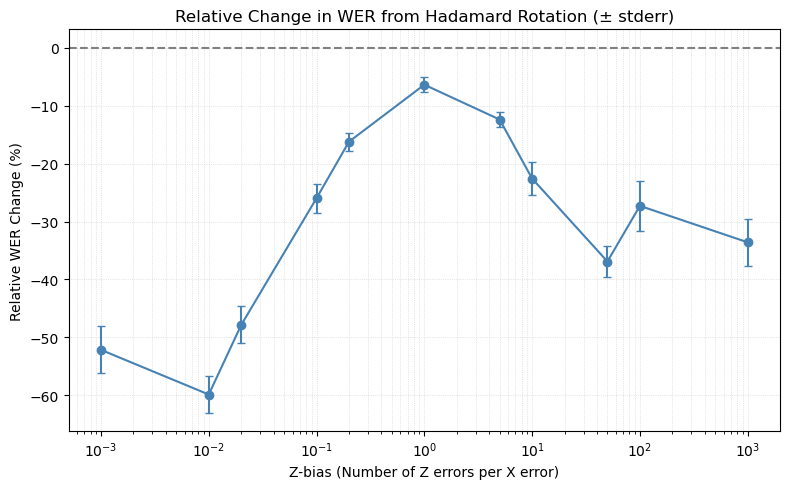

In [825]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem

# Clean 'channel_update' column
had["channel_update"] = (
    had["channel_update"]
    .replace("nan", "None")          # replace literal string 'nan'
    .fillna("None")                  # replace actual NaNs
    .astype(str)
)

color_map = {
    "x->z": "indianred",   # light red
    "z->x": "forestgreen",   # light green
    "None": "steelblue"     # optional default
}


# Recompute bias ratio in case it's missing
had["z_over_x"] = had["xyz_bias"].apply(lambda s: ast.literal_eval(s)[2] / ast.literal_eval(s)[0])

# Group + aggregate
y_var = 'WER_rel_change'
agg = had.groupby(["z_over_x", "channel_update"]).agg(
    mean_delta=(y_var, "mean"),
    std_delta=(y_var, "std"),
    count=(y_var, "count")
).reset_index()
agg["stderr"] = agg["std_delta"] / np.sqrt(agg["count"])

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
for name, g in agg.groupby("channel_update"):
    ax.errorbar(
        g["z_over_x"],
        g["mean_delta"]*100,
        yerr=g["stderr"]*50,
        marker="o",
        label=name,
        color=color_map.get(name, "black"),  # fallback to black if unknown
        capsize=3
    )

ax.set_xscale("log")
ax.set_xlabel("Z-bias (Number of Z errors per X error)")
ax.set_ylabel("Relative WER Change (%)")
ax.set_title("Relative Change in WER from Hadamard Rotation (± stderr)")
ax.axhline(0, color='gray', linestyle='--')
ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.6)
fig.tight_layout()
fig.savefig(f"{PLOT_DIR}/hadamard_delta_vs_bias.png")

### SS Application Analysis

In [962]:
ss = ss[~(ss["error_rate"] == 0)].copy()
ss = ss[~(ss["p_meas_err"] == 0)].copy()
ss = ss[~(ss["ssFalse"] == 1.0)].copy()
ss = ss[~(ss["ssTrue_applyFalse"] == 1.0)].copy()
ss = ss[~(ss["ssTrue_applyTrue"] == 1.0)].copy()
ss['combo_err_rate'] = ss['error_rate'] + ss['p_meas_err']
ss.reset_index(drop=True)

,error_rate,p_meas_err,xyz_bias,hadamard_rotate,channel_update,ssFalse,ssTrue_applyFalse,ssTrue_applyTrue,combo_err_rate
0,0.010,0.010,"[1, 1, 100]",False,NaN,0.024681,0.088025,0.075861,0.020
1,0.010,0.010,"[1, 1, 100]",True,NaN,0.008998,0.108661,0.075861,0.020
2,0.010,0.010,"[1, 1, 10]",False,NaN,0.014612,0.116159,0.075861,0.020
3,0.010,0.010,"[1, 1, 10]",True,NaN,0.009558,0.090260,0.072727,0.020
4,0.010,0.010,"[1, 1, 1]",False,NaN,0.009212,0.095696,0.074760,0.020
5,0.010,0.010,"[1, 1, 1]",True,NaN,0.008370,0.086021,0.071784,0.020
6,0.010,0.010,"[1, 1, 50]",False,NaN,0.021135,0.103303,0.073717,0.020
7,0.010,0.010,"[1, 1, 50]",True,NaN,0.009821,0.103303,0.073717,0.020
8,0.010,0.010,"[1, 1, 5]",False,NaN,0.012553,0.092787,0.068406,0.020
9,0.010,0.010,"[1, 1, 5]",True,NaN,0.008370,0.092787,0.069198,0.020


/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_22619/4145943234.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted, x="Mode", y="WER", palette=["lightgray", "orange", "seagreen"], ax=ax)


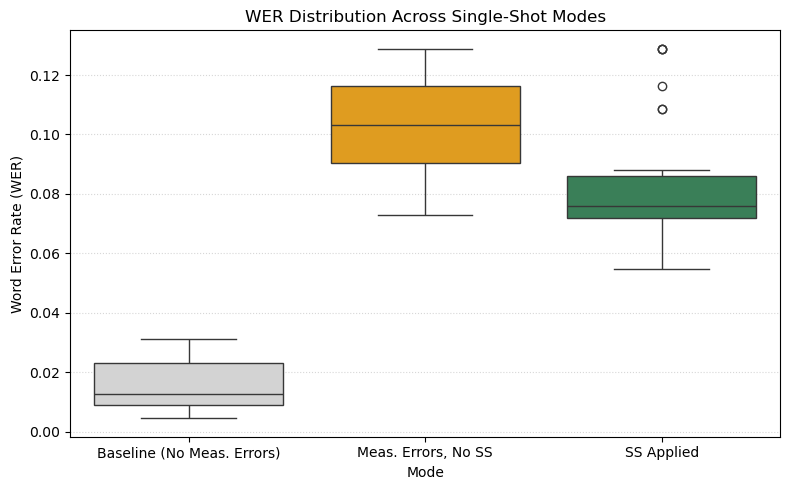

In [964]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt and relabel modes
melted = ss.melt(
    value_vars=["ssFalse", "ssTrue_applyFalse", "ssTrue_applyTrue"],
    var_name="Mode", value_name="WER"
)

label_map = {
    "ssFalse": "Baseline (No Meas. Errors)",
    "ssTrue_applyFalse": "Meas. Errors, No SS",
    "ssTrue_applyTrue": "SS Applied"
}
melted["Mode"] = melted["Mode"].map(label_map)

# Explicitly assign figure and axis
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=melted, x="Mode", y="WER", palette=["lightgray", "orange", "seagreen"], ax=ax)
ax.set_title("WER Distribution Across Single-Shot Modes")
ax.set_ylabel("Word Error Rate (WER)")
ax.grid(True, axis="y", linestyle=":", alpha=0.5)
fig.tight_layout()

# Save
fig.savefig(f"{PLOT_DIR}/ss_apply_box.png")


In [5]:
meta = pd.read_csv('metachecks.csv')

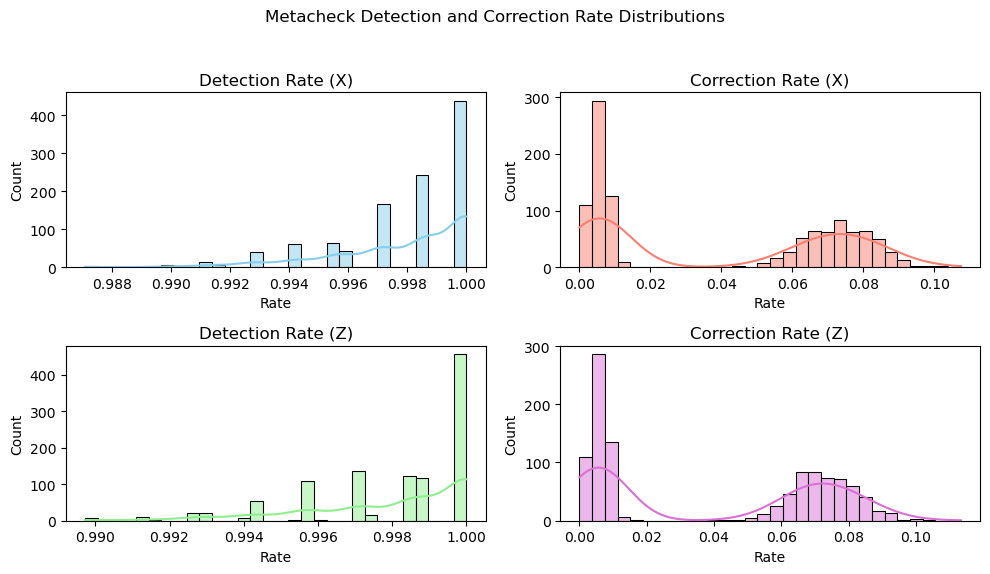

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Metacheck Detection and Correction Rate Distributions")

# Plot histograms
sns.histplot(meta["det_rate_x"], bins=30, ax=axs[0, 0], color="skyblue", kde=True)
axs[0, 0].set_title("Detection Rate (X)")
axs[0, 0].set_xlabel("Rate")
axs[0, 0].set_ylabel("Count")

sns.histplot(meta["corr_rate_x"], bins=30, ax=axs[0, 1], color="salmon", kde=True)
axs[0, 1].set_title("Correction Rate (X)")
axs[0, 1].set_xlabel("Rate")
axs[0, 1].set_ylabel("Count")

sns.histplot(meta["det_rate_z"], bins=30, ax=axs[1, 0], color="lightgreen", kde=True)
axs[1, 0].set_title("Detection Rate (Z)")
axs[1, 0].set_xlabel("Rate")
axs[1, 0].set_ylabel("Count")

sns.histplot(meta["corr_rate_z"], bins=30, ax=axs[1, 1], color="orchid", kde=True)
axs[1, 1].set_title("Correction Rate (Z)")
axs[1, 1].set_xlabel("Rate")
axs[1, 1].set_ylabel("Count")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(f"{PLOT_DIR}/metacheck.png")
plt.show()


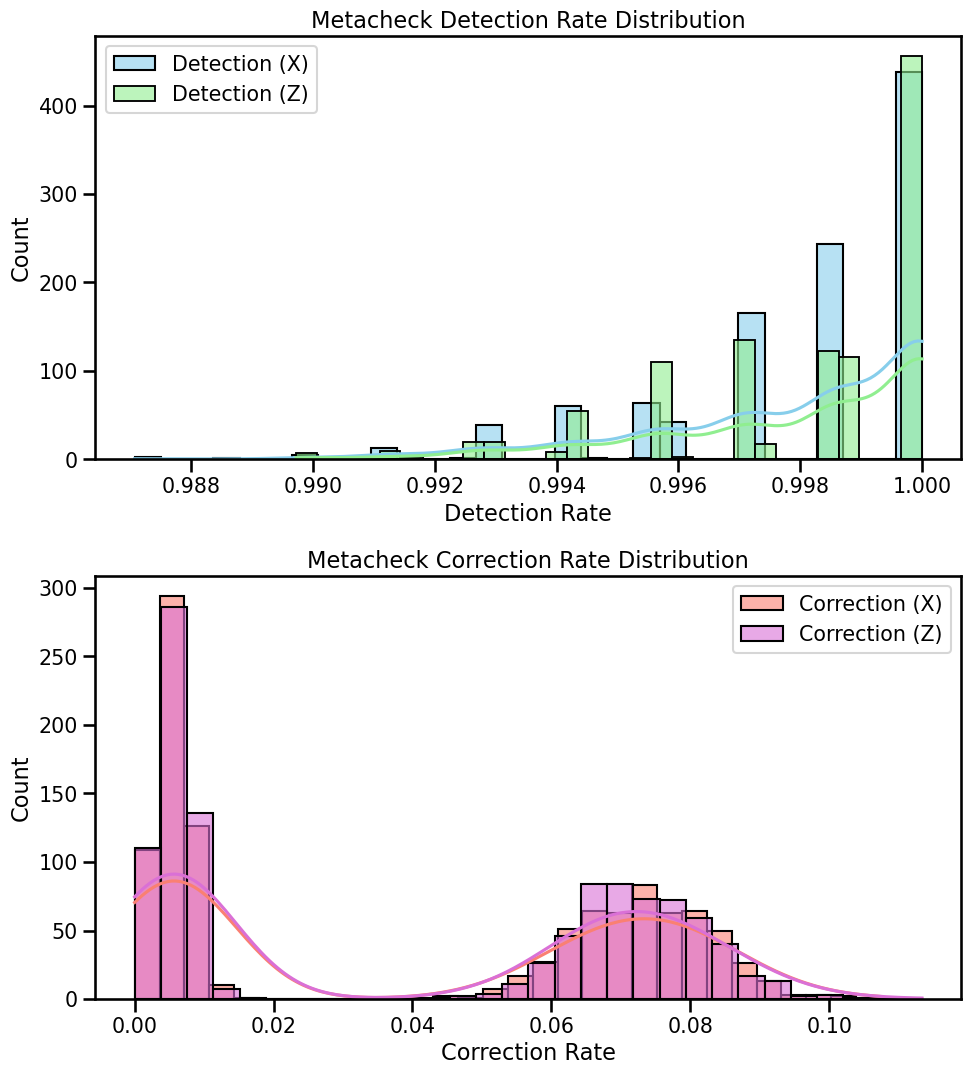

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 1, figsize=(10, 12))  # removed sharex=True
sns.set_context("talk", font_scale=.9)  # or "paper", "notebook", "poster"

# Top: Detection only
sns.histplot(meta["det_rate_x"], bins=30, ax=axs[0], color="skyblue", kde=True, label="Detection (X)", alpha=0.6)
sns.histplot(meta["det_rate_z"], bins=30, ax=axs[0], color="lightgreen", kde=True, label="Detection (Z)", alpha=0.6)
axs[0].set_title("Metacheck Detection Rate Distribution")
axs[0].set_xlabel("Detection Rate")
axs[0].set_ylabel("Count")
axs[0].legend()
axs[0].set_xlim(auto=True)  # ensure dynamic x-axis

# Bottom: Correction only
sns.histplot(meta["corr_rate_x"], bins=30, ax=axs[1], color="salmon", kde=True, label="Correction (X)", alpha=0.6)
sns.histplot(meta["corr_rate_z"], bins=30, ax=axs[1], color="orchid", kde=True, label="Correction (Z)", alpha=0.6)
axs[1].set_title("Metacheck Correction Rate Distribution")
axs[1].set_xlabel("Correction Rate")
axs[1].set_ylabel("Count")
axs[1].legend()
axs[1].set_xlim(auto=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(f"{PLOT_DIR}/metacheck_combined.png")
plt.show()


In [27]:
PLOT_DIR

'plots/v4'

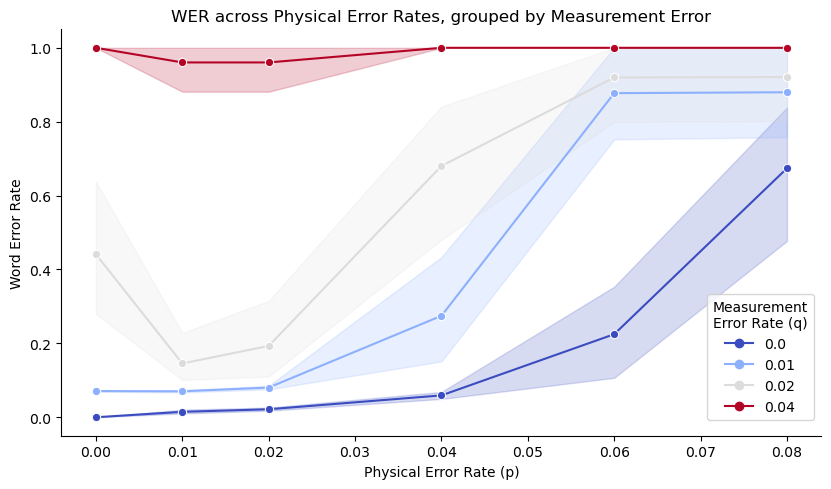

In [942]:
import seaborn as sns
import matplotlib.pyplot as plt

df_ss = df[df['apply_ss'] == True].copy()

# Create the plot
g = sns.relplot(
    data=df_ss,
    x="error_rate", y="OSDW_WER", hue="p_meas_err",
    kind="line", marker="o",
    palette="coolwarm", height=5, aspect=1.5
)

# Update the legend
g.set_axis_labels("Physical Error Rate (p)", "Word Error Rate")
g._legend.set_title("Measurement\nError Rate (q)")  # Rename legend title
g._legend.set_bbox_to_anchor((.975, .125))  # x=0.5 keeps it centered, y=-0.05 raises it
g._legend._loc = 4                                     # Center it below
g._legend.set_frame_on(True)                          # Optional: remove box

plt.title("WER across Physical Error Rates, grouped by Measurement Error")
ax.set_xlabel("Physical Error Rate (p)")
ax.set_ylabel("Word Error Rate")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/wer_phys.png")
plt.show()
